# Evaluation
This notebook is for inspecting the data and produce the desired results. It will use dataframes to do so.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import networkx as nx
import sys, os, csv, re, matplotlib
import numpy as np
from scipy import stats
os.chdir("..")

import src.parse as parse
from src.plot import plot_all, automatic_plotting
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [2]:
files = [file.rstrip(".vrp") for file in os.listdir("Instances/Uchoa") if (not file.endswith("sol"))]

methods = ["SPPRC","cyc2","ng8","ng20"]

In [5]:
dfs = {}
columns = ["ID",'instance','method','terminated','n',"K",'total time','sol_val']
finished_columns = ['final bound',"elementary","cyc2"]
data = pd.DataFrame(columns=columns + finished_columns)
pattern = r"(X-n(\d+)-k(\d+))-(\w+)\.log"
for i, log in enumerate((log for log in os.listdir("output_uchoa"))):
    ID = log.strip(".log")
    instance, n, K, method = re.search(pattern, log).groups()
    log = f"output_uchoa/{log}"
    finished = parse.log_finished(log)
    sol_val = parse.parse_sol_val(instance)
    if finished:
        elementary, cyc2 = parse.parse_footer(log)
    
    df = parse.parse_output(log)
    df["total time"] = df["total time"].cumsum()
    df = df[df.method == method]
    dfs[f'{instance}-{method}'] = df
    if finished:
        data = pd.concat((data,pd.DataFrame([[ID, instance,method, finished,n,K, df['total time'].iloc[-1], sol_val, df['upper_bound'].iloc[-1], elementary, cyc2]],columns=columns+finished_columns)))
    else:
        data = pd.concat((data,pd.DataFrame([[ID, instance,method, finished,n,K, df['total time'].iloc[-1], sol_val]],columns=columns)))
data = data.set_index("ID")
data['n'] = data['n'].astype(int)
data['total time'] = data['total time'].astype(float)
data['n/K'] = data['n'].astype(float) / data['K'].astype(float)
data['lb/I'] = data['final bound'].astype(float) / data['sol_val'].astype(float)

In [9]:
data.loc[(data.terminated == True) & (data.elementary == True)]

,instance,method,terminated,n,K,total time,sol_val,final bound,elementary,cyc2,n/K,lb/I
ID,,,,,,,,,,,,
X-n219-k73-ng8,X-n219-k73,ng8,True,219,73,0.2,117595\n,117208.0,True,True,3.000000,0.996709
X-n219-k73-ng20,X-n219-k73,ng20,True,219,73,0.5,117595\n,117208.0,True,True,3.000000,0.996709
X-n376-k94-ng20,X-n376-k94,ng20,True,376,94,172.2,147713\n,147298.8032,True,True,4.000000,0.997196
X-n219-k73-cyc2,X-n219-k73,cyc2,True,219,73,0.0,117595\n,117208.0,True,True,3.000000,0.996709
X-n195-k51-ng20,X-n195-k51,ng20,True,195,51,99.1,44225\n,43837.0518,True,True,3.823529,0.991228


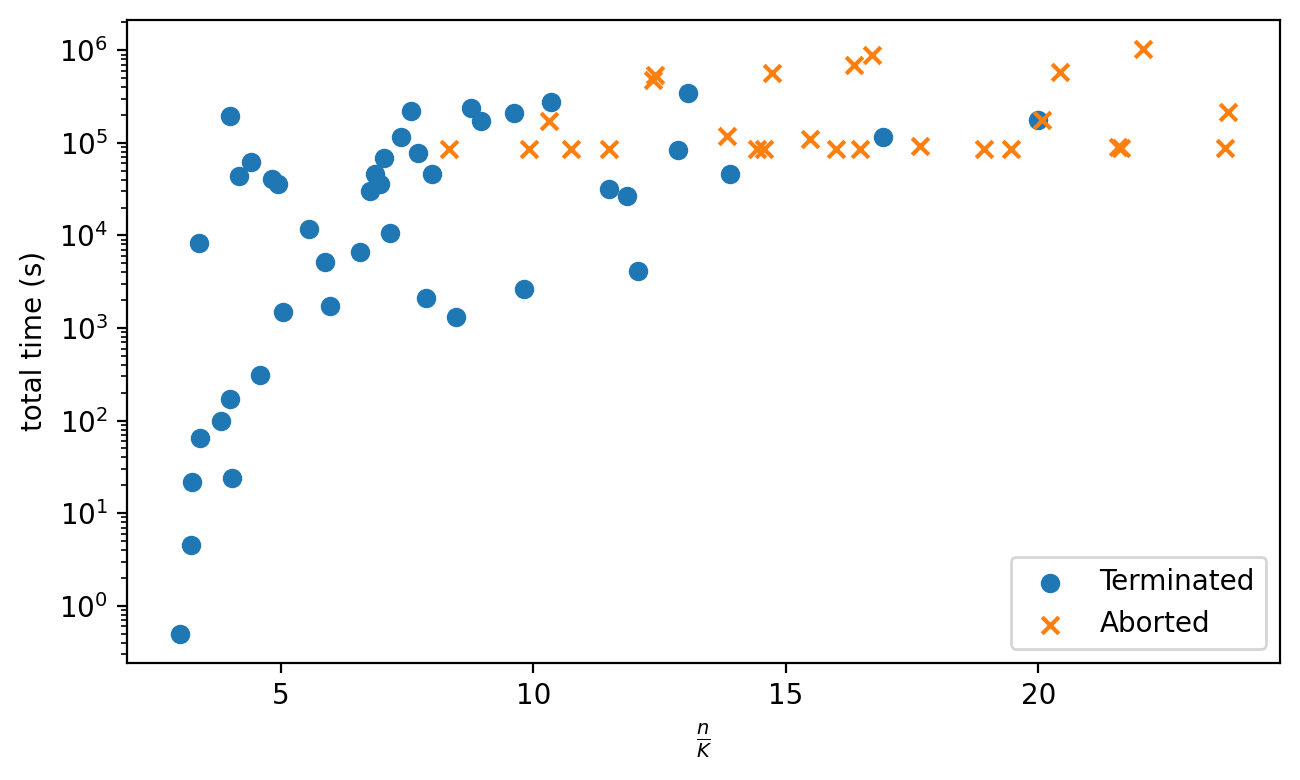

In [4]:
df = data.loc[data.method == "ng20"].copy()
df1 = df.loc[df.terminated == True]
df2 = df.loc[df.terminated == False]
plt.figure(figsize=(6.6,4),dpi=200)
plt.scatter(df1['n/K'],df1['total time'],label="Terminated")
plt.scatter(df2['n/K'],df2['total time'],label="Aborted",marker='x')
plt.xlabel(r"$\frac{n}{K}$")
plt.ylabel("total time (s)")
plt.yscale('log')
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig("plots/termination.pgf")
#TODO: Hier vier Subplots machen, die jeweils die Laufzeiten angeben für die vier Methoden

In [5]:
df = data.loc[data.method == "ng20"].copy()
df['buckets'] = (df['n'] / 50).round(0)
df1 = df.loc[df.terminated == True]
df2 = df.loc[df.terminated == False]
freq1 = df1.groupby('buckets').count()['instance']
freq2 = df2.groupby('buckets').count()['instance']

arr = pd.DataFrame((freq1,freq2)).fillna(0).to_numpy()
stats.chi2_contingency(arr)

(5.177845410403549,
 0.7384096799472049,
 8,
 array([[3.73913043, 6.23188406, 6.85507246, 6.23188406, 6.85507246,
         4.36231884, 3.73913043, 3.11594203, 1.86956522],
        [2.26086957, 3.76811594, 4.14492754, 3.76811594, 4.14492754,
         2.63768116, 2.26086957, 1.88405797, 1.13043478]]))

In [6]:
df = data.loc[data.method == "ng20"].copy()
df['n/K'] = (df['n/K']).astype(int)
df1 = df.loc[df.terminated == True]
df2 = df.loc[df.terminated == False]
freq1 = df1.groupby('n/K').count()['instance']
freq2 = df2.groupby('n/K').count()['instance']

arr = pd.DataFrame((freq1,freq2)).fillna(0).to_numpy()
arr
stats.chi2_contingency(arr)

(43.73291592128801,
 0.0016338770266359835,
 20,
 array([[3.73913043, 4.98550725, 2.49275362, 2.49275362, 3.73913043,
         3.11594203, 1.86956522, 1.86956522, 1.86956522, 2.49275362,
         1.86956522, 3.11594203, 1.86956522, 1.86956522, 0.62318841,
         0.62318841, 0.62318841, 0.62318841, 1.24637681, 0.62318841,
         1.24637681],
        [2.26086957, 3.01449275, 1.50724638, 1.50724638, 2.26086957,
         1.88405797, 1.13043478, 1.13043478, 1.13043478, 1.50724638,
         1.13043478, 1.88405797, 1.13043478, 1.13043478, 0.37681159,
         0.37681159, 0.37681159, 0.37681159, 0.75362319, 0.37681159,
         0.75362319]]))

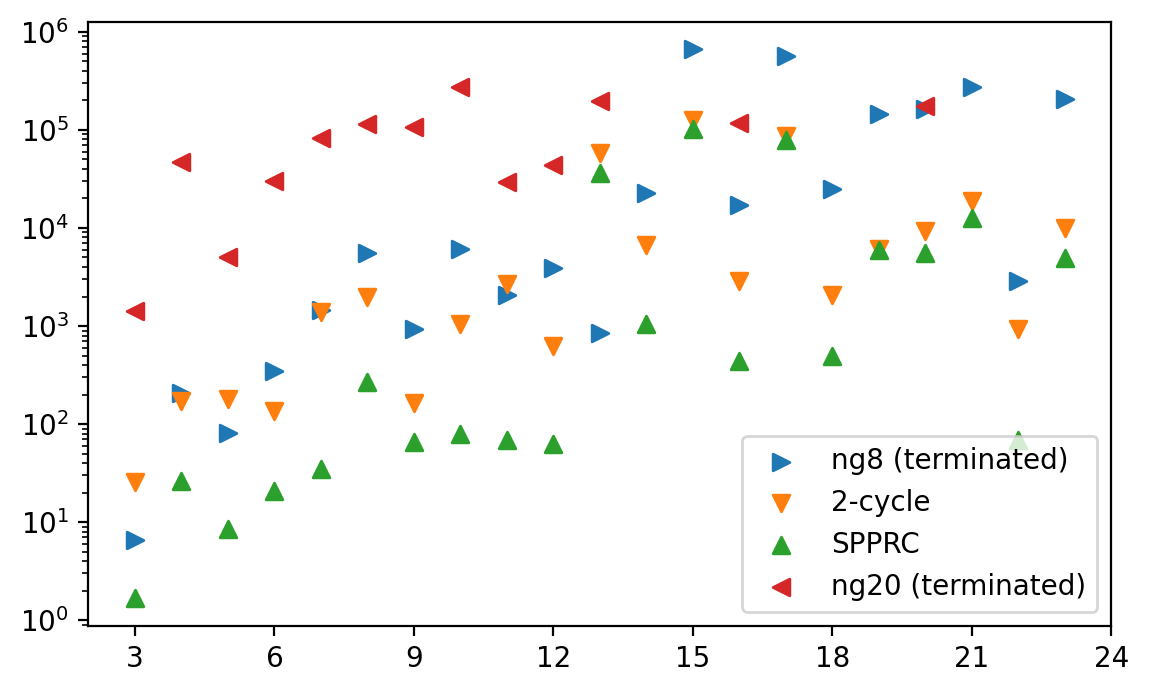

In [7]:
data['n/K'] = data['n/K'].astype(int)
data
plt.figure(figsize=(6.6,4),dpi=200)
df = data.loc[data.method == "ng8"]
df1 = df.loc[df.terminated == True].groupby('n/K').mean()
df2 = df.loc[df.terminated == False].groupby('n/K').mean()
plt.scatter(df1.index,df1['total time'],marker='>',label='ng8 (terminated)')
# plt.scatter(df2.index,df2['total time'],marker='o')
df3 = data.loc[data.method == "cyc2"].groupby('n/K').mean()
plt.scatter(df3.index,df3['total time'],marker='v',label='2-cycle')
df4 = data.loc[data.method == "SPPRC"].groupby('n/K').mean()
plt.scatter(df4.index,df4['total time'],marker='^',label='SPPRC')
plt.yscale('log')

df = data.loc[data.method == "ng20"].copy()
df1 = df.loc[df.terminated == True].groupby('n/K').mean()
df2 = df.loc[df.terminated == False].groupby('n/K').mean()
plt.scatter(df1.index,df1['total time'],label="ng20 (terminated)",marker='<')
# plt.scatter(df2.index,df2['total time'],label="Aborted",marker='x')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='lower right')

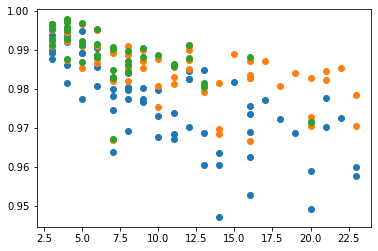

In [8]:
# Die Bound Qualität scheint zu sinken, je höher n/K ist.
df1 = data[data.method == "cyc2"]
df2 = data[data.method == "ng8"]
df3 = data[data.method == "ng20"]
plt.scatter(df1["n/K"],df1['lb/I'])
plt.scatter(df2["n/K"],df2['lb/I'])
plt.scatter(df3["n/K"],df3['lb/I'])
plt.show()

In [9]:
data.loc[(data.method == "ng20") & (data.terminated == False)]

,instance,method,terminated,n,K,total time,sol_val,final bound,n/K,lb/I
ID,,,,,,,,,,
X-n284-k15-ng20,X-n284-k15,ng20,False,284,15,86702.1,20226\n,NaN,18,NaN
X-n256-k16-ng20,X-n256-k16,ng20,False,256,16,86471.9,18839\n,NaN,16,NaN
X-n167-k10-ng20,X-n167-k10,ng20,False,167,10,881888.6,20557\n,NaN,16,NaN
X-n233-k16-ng20,X-n233-k16,ng20,False,233,16,86570.7,19230\n,NaN,14,NaN
X-n367-k17-ng20,X-n367-k17,ng20,False,367,17,90707.5,22814\n,NaN,21,NaN
X-n331-k15-ng20,X-n331-k15,ng20,False,331,15,1027720.9,31102\n,NaN,22,NaN
X-n449-k29-ng20,X-n449-k29,ng20,False,449,29,109982.8,55233\n,NaN,15,NaN
X-n190-k8-ng20,X-n190-k8,ng20,False,190,8,218124.6,16980\n,NaN,23,NaN
X-n459-k26-ng20,X-n459-k26,ng20,False,459,26,92471.5,24139\n,NaN,17,NaN


## Create Table

In [10]:
hierarchy = {"ng20":"ng8","ng8":"cyc2","cyc2":"SPPRC"}

c = 0.99

data['I'] = np.nan 
data['t'] = np.nan
data['lb_rel'] = np.nan
data['time_beaten'] = False

for index, row in data.iterrows():
    if row['terminated']:
        df = dfs[index]
        if row['method'] in hierarchy.keys():
            instance = row["instance"]
            method = row["method"]
            bound_sup = data['final bound'][f"{instance}-{hierarchy[method]}"]
            time_sup = data['total time'][f"{instance}-{hierarchy[method]}"]
            bound_c = row['final bound'] * c
            df_beaten = df[df['lower_bound'] >= bound_sup]
            df_c = df[df['lower_bound'] >= bound_c]
            
            data.loc[index,'lb_rel'] = bound_sup / row['final bound']
            data.loc[index, 'I'] = df_beaten.shape[0] - 1
            data.loc[index, 't'] = df_beaten['total time'].iloc[-1] - df_beaten.iloc[0,df_beaten.columns.get_loc('total time')]
            
            data.loc[index, 'Ic'] = df_c.shape[0] - 1
            data.loc[index, 'tc'] = df_c['total time'].iloc[-1] - df_c.iloc[0,df_c.columns.get_loc('total time')]
            
            if row['total time'] < time_sup:
                data.loc[index, 'time_beaten'] = True
    
data["t/I"] = data['t'] / (data["I"])
data["%"] = data['t'].divide(data['total time'],fill_value=np.nan)
data["%c"] = data['tc'].divide(data['total time'],fill_value=np.nan)
data["tt"] = data['total time']
data = data.round({"total time":0, "t":0,"tc":0, "%":2,"%c":2,"t/I":0})
data

,instance,method,terminated,n,K,total time,sol_val,final bound,n/K,lb/I,I,t,lb_rel,time_beaten,Ic,tc,t/I,%,%c,tt
ID,,,,,,,,,,,,,,,,,,,,
X-n247-k50-SPPRC,X-n247-k50,SPPRC,True,247,50,86.0,37274\n,36809.2485,4,0.987531,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,86.1
X-n153-k22-cyc2,X-n153-k22,cyc2,True,153,22,183.0,21220\n,20913.6641,6,0.985564,2.0,5.0,0.994308,False,3.0,8.0,3.0,0.03,0.04,182.8
X-n313-k71-SPPRC,X-n313-k71,SPPRC,True,313,71,42.0,94043\n,92451.9331,4,0.983081,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,42.4
X-n106-k14-ng20,X-n106-k14,ng20,True,106,14,222048.0,26362\n,25498.8697,7,0.967259,0.0,0.0,0.999603,False,0.0,0.0,NaN,0.00,0.00,222048.1
X-n275-k28-ng20,X-n275-k28,ng20,True,275,28,2636.0,21245\n,21045.6349,9,0.990616,0.0,0.0,0.999420,False,1.0,767.0,NaN,0.00,0.29,2636.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X-n190-k8-cyc2,X-n190-k8,cyc2,True,190,8,572.0,16980\n,16303.7537,23,0.960174,48.0,291.0,0.982448,False,35.0,241.0,6.0,0.51,0.42,572.3
X-n251-k28-ng8,X-n251-k28,ng8,True,251,28,641.0,38684\n,38111.906,8,0.985211,2.0,294.0,0.992022,False,2.0,294.0,147.0,0.46,0.46,640.8
X-n237-k14-cyc2,X-n237-k14,cyc2,True,237,14,81.0,27042\n,26382.1586,16,0.975599,21.0,34.0,0.971804,False,14.0,22.0,2.0,0.42,0.27,81.1


TODO: Wie wäre es sich hier noch anzuschauen, was Signale zum erkennen von Tailing Off sind? An der Stelle könnte ich mir die Bounds anschauen.

In [10]:
data[data.time_beaten == True]

,instance,method,terminated,n,K,total time,sol_val,final bound,n/K,lb/I,I,t,lb_rel,time_beaten,Ic,tc,t/I,%,%c,tt
ID,,,,,,,,,,,,,,,,,,,,
X-n439-k37-ng8,X-n439-k37,ng8,True,439,37,112.0,36391\n,35867.9808,11,0.985628,6.0,64.0,0.987999,True,6.0,64.0,11.0,0.57,0.57,112.4
X-n344-k43-ng8,X-n344-k43,ng8,True,344,43,150.0,42050\n,41473.3662,8,0.986287,0.0,0.0,0.993325,True,0.0,0.0,NaN,0.00,0.00,150.2
X-n148-k46-ng8,X-n148-k46,ng8,True,148,46,1.0,43448\n,43124.5363,3,0.992555,0.0,0.0,0.997546,True,1.0,0.0,NaN,0.00,0.17,0.6
X-n469-k138-ng8,X-n469-k138,ng8,True,469,138,13.0,221824\n,220985.548,3,0.996220,0.0,0.0,0.999440,True,0.0,0.0,NaN,0.00,0.00,12.6
X-n429-k61-ng8,X-n429-k61,ng8,True,429,61,2174.0,65449\n,64751.1591,7,0.989338,1.0,571.0,0.993512,True,1.0,571.0,571.0,0.26,0.26,2174.3
X-n153-k22-ng8,X-n153-k22,ng8,True,153,22,101.0,21220\n,20963.2191,6,0.987899,2.0,10.0,0.997636,True,5.0,26.0,5.0,0.10,0.26,101.0
X-n195-k51-ng8,X-n195-k51,ng8,True,195,51,6.0,44225\n,43824.6508,3,0.990947,0.0,0.0,0.996826,True,1.0,1.0,NaN,0.00,0.20,5.9
X-n322-k28-ng8,X-n322-k28,ng8,True,322,28,5547.0,29834\n,29329.1104,11,0.983077,4.0,2905.0,0.983954,True,3.0,2905.0,726.0,0.52,0.52,5546.9
X-n110-k13-ng8,X-n110-k13,ng8,True,110,13,22.0,14971\n,14701.2871,8,0.981984,2.0,3.0,0.987044,True,1.0,2.0,2.0,0.15,0.08,22.0


In [102]:
table = data[['instance','method','I','t','tt',"%","t/I","n/K"]]
table = table[table.method != "SPPRC"]
# table = table[table.method == "ng8"]
table["n/K"] = table["n/K"].astype(int)
table["%"] = (table["%"]*100)
table = table.groupby(["n/K","method"]).mean().unstack('method')
table.columns = table.columns.swaplevel()
_, index = table.columns.sortlevel()
table = table.iloc[:,index]
# ser = table[("","n/K")]
table = table[['cyc2','ng8','ng20']]
# table.style.format("{:.0f}")

In [113]:
print(data[(data.method == "ng20") &(data.I == 0) & (data.terminated == True)].shape[0])
data[(data.method == 'ng20')& (data.terminated == True)].shape[0]

26


43

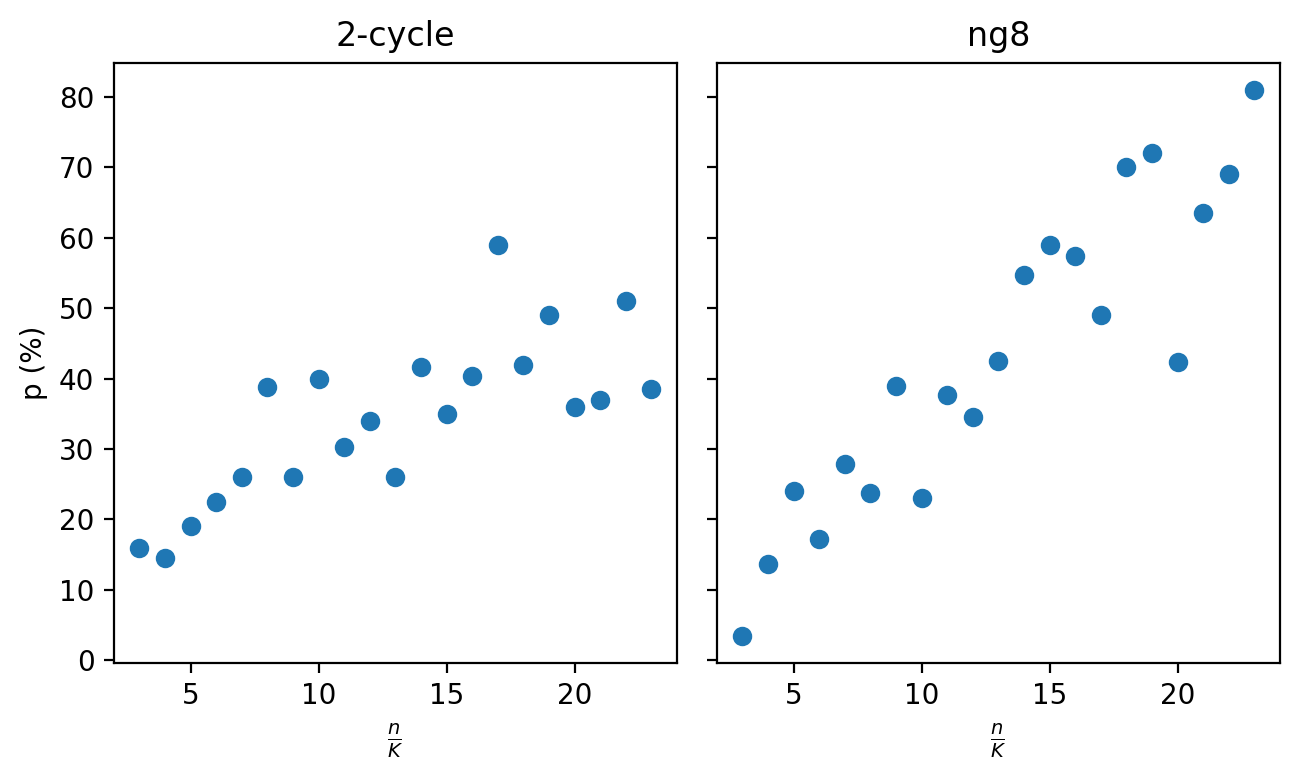

In [99]:
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True,figsize=(6.6,4),dpi=200)
ax1.scatter(table.index,table['cyc2',"%"])
ax1.set_title("2-cycle")
ax1.set_xlabel(r"$\frac {n} {K}$")
ax2.scatter(table.index,table['ng8',"%"])
ax2.set_title("ng8")
ax2.set_xlabel(r"$\frac {n} {K}$")
ax1.set_ylabel(r"p (%)")
# plt.xlabel("test")
# ax3.scatter(table.index,table['ng20',"%"])
# ax = plt.gca()
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("plots/percentage_flexibility.pgf")
plt.show()

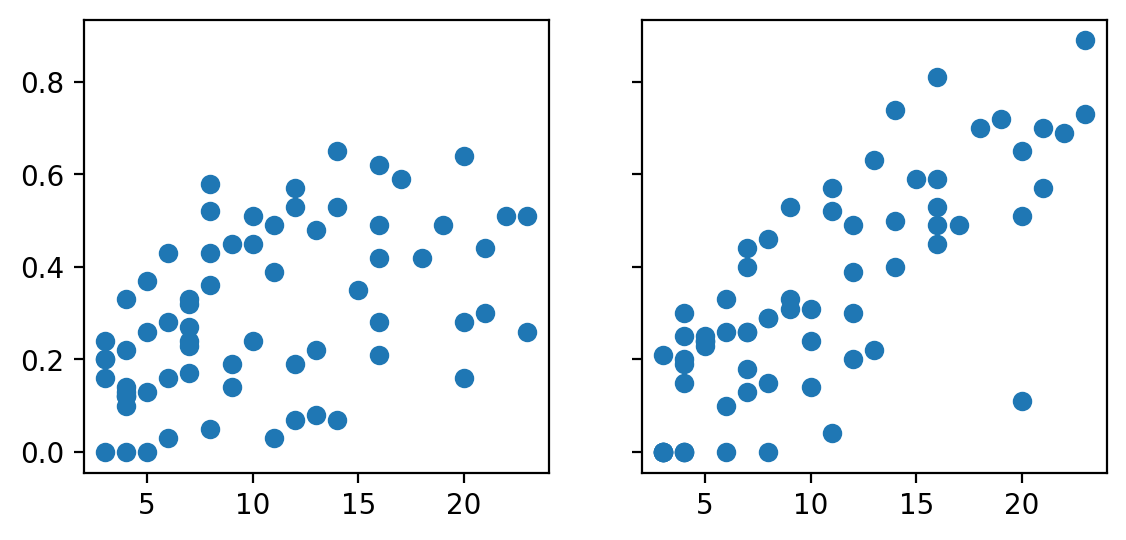

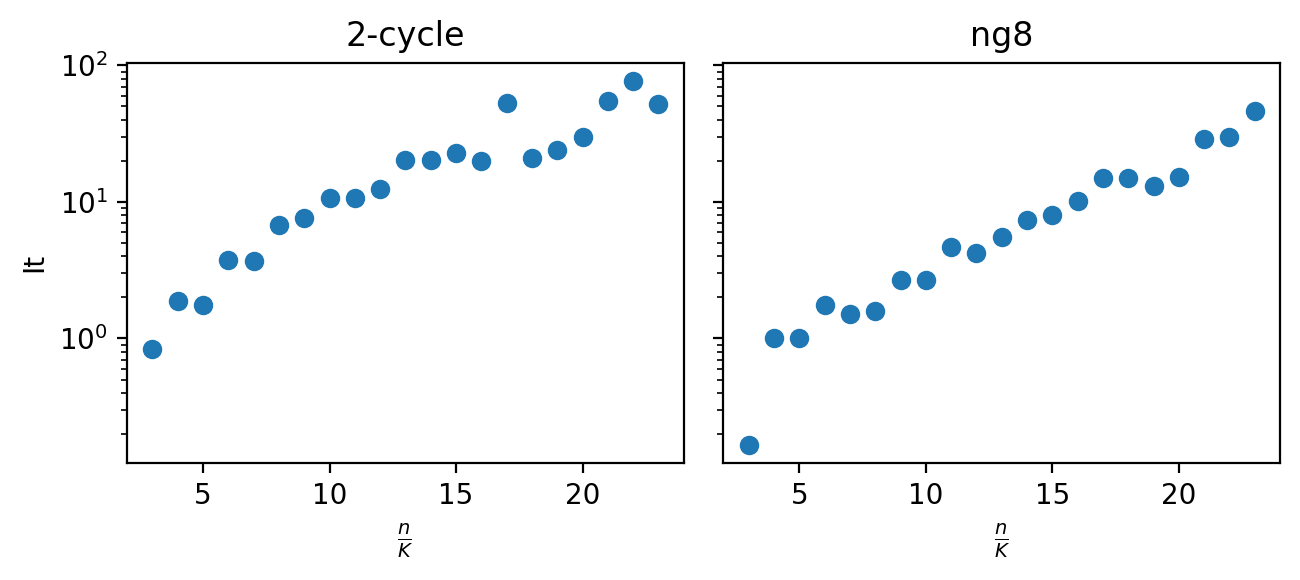

In [69]:
# Die Streuung scheint unterschiedlich groß zu sein! Bei n8 etwas kleiner, ber cyc2 deutlich größer
subset1 = data[data.method == "ng8"]
subset2 = data[data.method == "cyc2"]
# fig, axs = plt.subplots(2, 2,sharey=True,figsize=(6.6,6),dpi=200)
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True,figsize=(6.6,3),dpi=200)
ax2.scatter(subset1["n/K"],subset1["%"])
ax1.scatter(subset2["n/K"],subset2["%"])
plt.show()
fig, (ax1, ax2) = plt.subplots(ncols=2,sharey=True,figsize=(6.6,3),dpi=200)
ax1.scatter(table.index,table['cyc2',"I"])
ax1.set_yscale("log")
ax1.set_title("2-cycle")
ax1.set_xlabel(r"$\frac {n} {K}$")
ax1.set_ylabel("It")
ax2.set_title("ng8")
ax2.scatter(table.index,table['ng8',"I"])
ax2.set_xlabel(r"$\frac {n} {K}$")
plt.tight_layout()
plt.savefig("plots/it_flexibility.pgf")
# plt.show()
# Das ganze scheint ebenso für cyc2 und % zu gelten.
# Aber nicht für ng20!

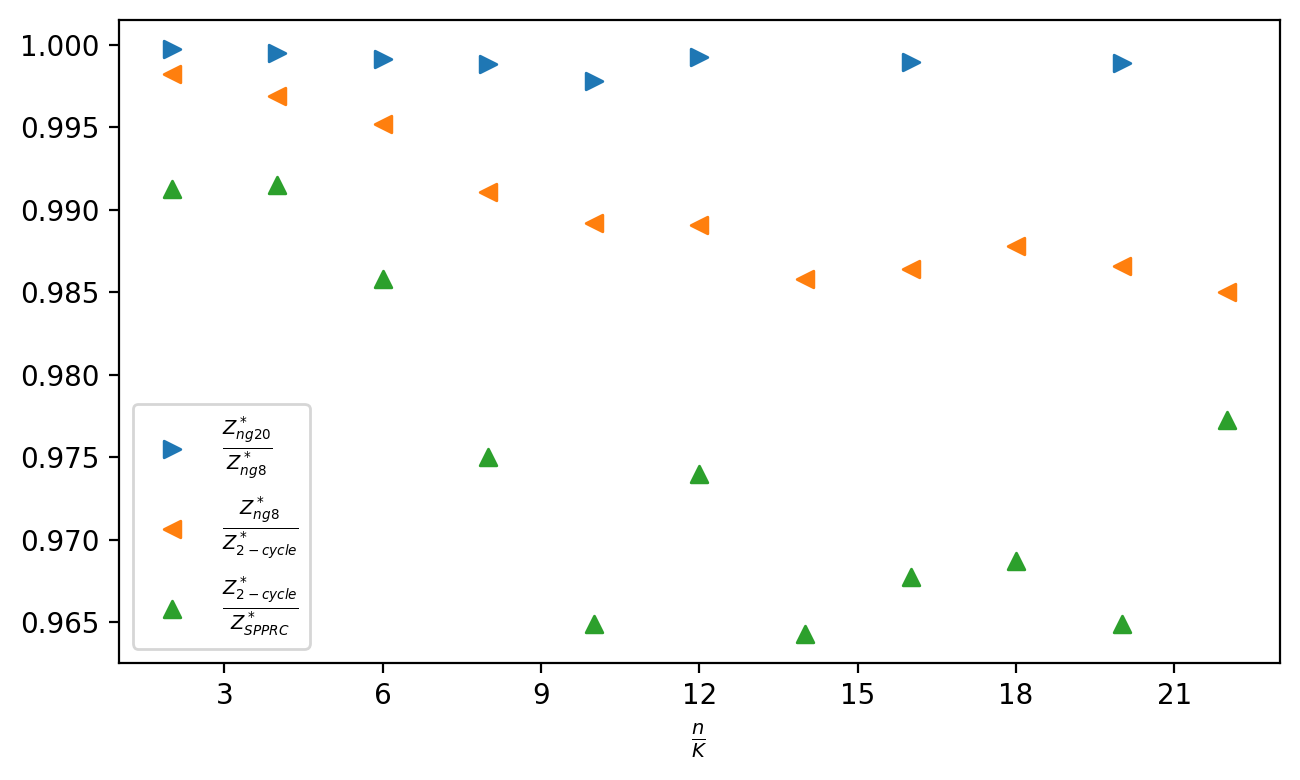

In [125]:
df = data.copy()
df["n/K"] = df["n/K"].astype(int) // 2 * 2
df2 = df[df.method == 'ng8'].groupby("n/K").mean()
df1 = df[df.method == 'ng20'].groupby("n/K").mean()
df3 = df[df.method == 'cyc2'].groupby("n/K").mean()
plt.figure(figsize=(6.6,4),dpi=200)
plt.scatter(df1.index,df1['lb_rel'],marker='>',label=r"$\frac{Z^*_{ng20}}{Z^*_{ng8}}$")
plt.scatter(df2.index,df2['lb_rel'],marker="<",label=r"$\frac{Z^*_{ng8}}{Z^*_{2-cycle}}$")
plt.scatter(df3.index,df3['lb_rel'],marker='^',label=r"$\frac{Z^*_{2-cycle}}{Z^*_{SPPRC}}$")
plt.xlabel(r"$\frac{n}{K}$")
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig("plots/lb_rel.pgf")

In [161]:
df = data.loc[data.method == "ng8"][["n/K","lb_rel"]]

print(stats.spearmanr(df.to_numpy(),axis=0, nan_policy="omit",alternative="less"))

df = df.loc[data['n/K'] >= 8]
print(stats.spearmanr(df.to_numpy(),axis=0, nan_policy="omit",alternative="less"))
# Dieser Test ist mir zu schwach. Ich lasse den Punkt aus.

SpearmanrResult(correlation=-0.8148978657477377, pvalue=1.386482576973016e-17)
SpearmanrResult(correlation=-0.3983644729805852, pvalue=0.005449154757269422)


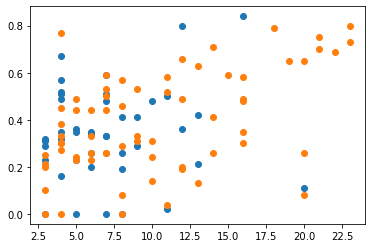

In [36]:
df = data.copy()
df["n/K"] = df["n/K"].astype(int)
df1 = df[df.method == 'ng20']
df2 = df[df.method == 'ng8']
plt.scatter(df1['n/K'],df1['%c'])
plt.scatter(df2['n/K'],df2['%c'])

In [57]:
table = data[['instance','method','I','t','tt',"%","n/K"]]
table = table[table.method != "SPPRC"]
table = table.pivot(index=["instance","n/K"],columns='method')
table = table.reset_index("n/K")
table.columns = table.columns.swaplevel()
_, index = table.columns.sortlevel()
table = table.iloc[:,index]
ser = table[("","n/K")]
table = table[['cyc2','ng8','ng20']]
table.insert(0,"n/K",ser)
format_dict = {("ng8","%"):"{:.0%}".format, ("ng20","%"):"{:.0%}".format, ("cyc2","%"):"{:.0%}".format}
table.iloc[:40].to_latex("output/table_small.tex",formatters=format_dict,float_format="%.0f",na_rep="-")
table.iloc[40:].to_latex("output/table_large.tex",formatters=format_dict,float_format="%.0f",na_rep="-")
table.style.format("{:.0f}")

/var/folders/tv/pzvp6rwx029b6p4rgqv2cx0h0000gn/T/ipykernel_35188/2480925792.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.iloc[:40].to_latex("output/table_small.tex",formatters=format_dict,float_format="%.0f",na_rep="-")
/var/folders/tv/pzvp6rwx029b6p4rgqv2cx0h0000gn/T/ipykernel_35188/2480925792.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table.iloc[40:].to_latex("output/table_large.tex",formatters=format_dict,float_format="%.0f",na_rep="-")
